Stock price prediction using LSTM

In [22]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

Get stock name and prediction duration from user input

In [23]:
stock = input("Enter stock name to predict prices: ")
duration = int(input("Enter number of days to predict stock prices: "))

Enter stock name to predict prices: AAPL
Enter number of days to predict stock prices: 10


Set sequence length for input data

In [24]:
sequence_length = 100

Download stock data using yfinance

In [25]:
df = yf.download(stock, start="2010-01-01", end=None)
df = df.reset_index()

[*********************100%%**********************]  1 of 1 completed


Split data into training and testing sets

In [26]:
data_training = pd.DataFrame(df["Close"][:int(len(df) * 0.70)])
data_testing = pd.DataFrame(df["Close"][int(len(df) * 0.70): int(len(df))])

Initialize MinMaxScaler to scale data

In [27]:
scaler = MinMaxScaler()
data_training_array = scaler.fit_transform(data_training.values.reshape(-1, 1))

Prepare training data and labels

In [28]:
x_train = []
y_train = []

for i in range(data_training_array.shape[0] - 100):
    x_train.append(data_training_array[i: 100 + i, 0])
    y_train.append(data_training_array[100 + i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

Create the LSTM model

In [29]:
model = keras.Sequential([
    keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(60, activation='relu', return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(80, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1)]
)

Compile and train the model

In [30]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=30, batch_size=30)

Epoch 1/30
77/77 [==============================] - 16s 157ms/step - loss: 0.0341
Epoch 2/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0069
Epoch 3/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0062
Epoch 4/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0052
Epoch 5/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0053
Epoch 6/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0047
Epoch 7/30
77/77 [==============================] - 12s 158ms/step - loss: 0.0046
Epoch 8/30
77/77 [==============================] - 12s 154ms/step - loss: 0.0049
Epoch 9/30
77/77 [==============================] - 12s 151ms/step - loss: 0.0042
Epoch 10/30
77/77 [==============================] - 12s 151ms/step - loss: 0.0035
Epoch 11/30
77/77 [==============================] - 12s 156ms/step - loss: 0.0039
Epoch 12/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0036
Epoch 13/30
7

Prepare data for predicting future values

In [31]:
past_days = data_training.tail(100)
new_df = past_days._append(data_testing, ignore_index=True)
input_data = scaler.fit_transform(new_df)

Prepare test data and labels for evaluation

In [32]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100: i])
    y_test.append(input_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

Predict the test data using the trained model

In [33]:
y_predicted = model.predict(x_test)

33/33 [==============================] - 2s 40ms/step


Scale back the predicted and true values

In [34]:
scale_factor = 1/0.02099617
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

Prepare data for predicting future values

In [35]:
x_future = [input_data[-100:]]

future_predictions = []

Predict future values

In [36]:
for i in range(duration):
    x_future_array = np.array(x_future)
    x_future_array = np.reshape(x_future_array, (x_future_array.shape[0], x_future_array.shape[1], 1))
    future_prediction = model.predict(x_future_array)

    future_predictions.append(future_prediction[0, 0])

    x_future[0] = np.concatenate((x_future[0][1:], future_prediction), axis=None)

1/1 [==============================] - 0s 41ms/step


Inverse transform and prepare future time indices

In [37]:
future_predictions_array = np.array(future_predictions)

y_future = scaler.inverse_transform(future_predictions_array.reshape(-1, 1))

future_time_indices = pd.date_range(start=df["Date"].iloc[-1], periods=duration, freq="D")

Plot historical and predicted prices

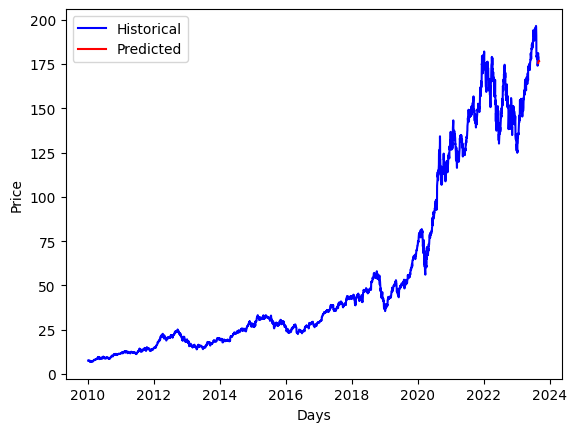

In [38]:
plt.plot(df["Date"], df["Close"], label='Historical', color='b')
plt.plot(future_time_indices, y_future, label='Predicted', color='r')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()